##### Figure 7
# Map of 10-m HRRR winds surrounding HWKC1 that are greater than 90th and 99th percentile

In [1]:
%matplotlib inline
import h5py
import matplotlib.pyplot as plt
import multiprocessing
import numpy as np
from mpl_toolkits.basemap import Basemap

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_downloads.HRRR_S3 import *
from BB_wx_calcs.wind import wind_uv_to_spd
from BB_basemap.draw_maps import draw_CONUS_HRRR_map
from BB_MesoWest.MesoWest_STNinfo import get_MW_location_dict
from BB_MesoWest.MesoWest_timeseries import get_mesowest_ts
from BB_MesoWest.MesoWest_nearesttime import get_mesowest_nearesttime
from BB_MesoWest.MesoWest_percentiles import get_mesowest_percentiles
from BB_data.grid_manager import pluck_point_new
from BB_wx_calcs.wind import wind_uv_to_spd

In [2]:
from matplotlib.dates import DateFormatter
formatter = DateFormatter('%b')

import matplotlib as mpl 
two_column = 5.5
one_column = 3.2
twothird_column = 6.8
mpl.rcParams['figure.figsize'] = [twothird_column, twothird_column]
mpl.rcParams['figure.titlesize'] = 12
mpl.rcParams['figure.titleweight'] = 'bold'
mpl.rcParams['xtick.labelsize'] = 8
mpl.rcParams['ytick.labelsize'] = 8
mpl.rcParams['axes.labelsize'] = 8
mpl.rcParams['axes.titlesize'] = 10
mpl.rcParams['lines.linewidth'] = 1.8
mpl.rcParams['grid.linewidth'] = .25
mpl.rcParams['figure.subplot.wspace'] = 0.03
mpl.rcParams['figure.subplot.hspace'] = 0.05
mpl.rcParams['legend.fontsize'] = 7
mpl.rcParams['legend.framealpha'] = .75
mpl.rcParams['legend.loc'] = 'best'
mpl.rcParams['savefig.bbox'] = 'tight'
    
mpl.rcParams['savefig.dpi'] = 600    # 600 for print

AMS Journal Figure size chart.  
_Note: Figsize parameter may differ from what is actually generated_

| One Colulmn | 2/3 Page   | Two Columns   | More than 2 columns  |
|---|---|---|---|
| 3.2   | 4.5  | 5.5  | 6.5  |


---

## Create Map Object

In [3]:
# Map Center Location, a MesoWest station ID
stn = 'HWKC1'

In [4]:
# HRRR lat/lon grid
DIR = '/uufs/chpc.utah.edu/common/home/horel-group2/blaylock/HRRR_OSG/'
latlon_file = h5py.File(DIR+'OSG_HRRR_latlon.h5', 'r')
lat = latlon_file['latitude'].value
lon = latlon_file['longitude'].value

In [5]:
# Pluck point nearest MesoWest Station
LD = get_MW_location_dict(stn)
MWlat = LD[stn]['latitude']
MWlon = LD[stn]['longitude']
point = pluck_point_new(MWlat, MWlon, lat, lon)
x = point[0][0]
y = point[1][0]

In [6]:
# Create Map Object
m = Basemap(projection='cyl', resolution='f', area_thresh=1000,
            llcrnrlon=MWlon-.3,  urcrnrlon=MWlon+.3,
            llcrnrlat=MWlat-.3, urcrnrlat=MWlat+.3)

## Retrieve HRRR data

In [7]:
# valid Date of model forecast time
DATE = datetime(2017, 10, 9, 6)

# Forecast
fxx = 6

# model run date
RUNDATE = DATE-timedelta(hours=fxx)

# Retreive HRRR model analysis
Hu = get_hrrr_variable(RUNDATE, 'UGRD:10 m', fxx=fxx, verbose=False)
Hv = get_hrrr_variable(RUNDATE, 'VGRD:10 m', fxx=fxx, verbose=False)

# Convert U and V to wind speed
speed = wind_uv_to_spd(Hu['value'], Hv['value'])

In [8]:
# Print some info to confirm the data we are retrieving
print 'HRRR run\t:\t %s' % Hu['anlys']
print 'HRRR valid\t:\t %s' % Hu['valid']
print ''

HRRR run	:	 2017-10-09 00:00:00
HRRR valid	:	 2017-10-09 06:00:00



## Retrieve HRRR Percentile Grids

In [9]:
def get_percentile(DATE, var, p=95):
    '''
    DATE - a datetime object
    var  - the variable you want to retreive (ex. UVGRD:10, TMP:2 m, DPT:2 m, UVGRD:80 m)
    p    - the percentile you want to retrieve from the data
    
    returns a grid for the HRRR domain of the requested percentile and data
    '''
    variable = var.replace(':', '_').replace(' ', '_')
    FILE = 'hourly30/%s/OSG_HRRR_%s_m%02d_d%02d_h%02d_f00.h5' % ((variable, variable, DATE.month, DATE.day, DATE.hour))
    
    with h5py.File(DIR+FILE, 'r') as f:
        PP = f["p%02d" % p][:]
    
    # Convert Units
    if var == 'TMP:2 m' or var == 'DPT:2 m':
        PP -= 273.15
    
    return PP

In [11]:
var = 'UVGRD:10 m'
p95 = get_percentile(DATE, var, p=95)

## Create Figure

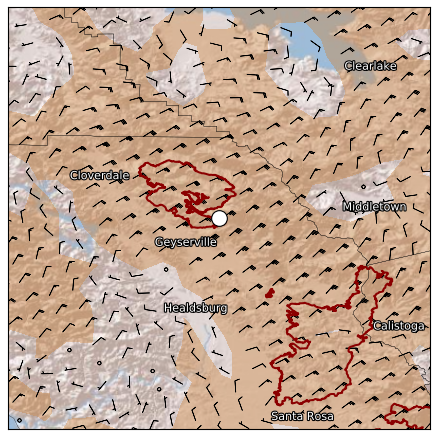

In [13]:
add_cities = True
add_fireperim = True

# Add basemap background
m.arcgisimage(service='World_Shaded_Relief', dpi=1000)


# Plot contour where speed is greater than the 95th percentile
m.contourf(lon, lat, speed-p95,
                    levels=[0,100],
                    colors=('peru'),
                    alpha=.4,
                    zorder=1,
                    latlon=True)


# Wind barbs
# Cut box for plotting barbs
bfr=15
thin=1
Cgridlat = lat[x-bfr:x+bfr, y-bfr:y+bfr]
Cgridlon = lon[x-bfr:x+bfr, y-bfr:y+bfr]
CHu = Hu['value'][x-bfr:x+bfr, y-bfr:y+bfr]
CHv = Hv['value'][x-bfr:x+bfr, y-bfr:y+bfr]
m.barbs(Cgridlon[::thin,::thin], Cgridlat[::thin,::thin],
        CHu[::thin,::thin], CHv[::thin,::thin],
        zorder=2, length=4.5, linewidth=.65,
        barb_increments={'half':2.5, 'full':5,'flag':25},
        latlon=True)

# Point of MesoWest station (map center)
m.scatter(MWlon, MWlat, latlon=True, c='w', s=200, zorder=3)

# Add county lines
m.drawcounties(linewidth=.25)

#plt.title(DATE.strftime('%Y-%b-%d %H:%M UTC'), loc='left')
#plt.title(stn, fontweight='bold', loc='right')

if add_cities:
    cities = {'Geyserville': (38.700078, -122.883772),
              'Santa Rosa': (38.452214, -122.717661),
              'Healdsburg': (38.606396, -122.869722),
              'Cloverdale': (38.794959, -123.006450),
              'Middletown': (38.750411, -122.615162),
              'Clearlake': (38.950727, -122.620816),
              'Calistoga': (38.580932, -122.580472)}

    import matplotlib.patheffects as path_effects
    for c in cities:
        text = plt.text(cities[c][1], cities[c][0], c,
                        color='white', ha='center', va='center')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                               path_effects.Normal()])


if add_fireperim:
    pocket = '/uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/fire_shapefiles/2017_pocket/ca_pocket_20171025_2130_dd83'
    m.readshapefile(pocket, 'pocket', drawbounds=False)
    
    tubbs = '/uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/fire_shapefiles/2017_tubbs/ca_tubbs_20171025_2130_dd83'
    m.readshapefile(tubbs, 'tubbs', drawbounds=False)
    
    nuns = '/uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/fire_shapefiles/2017_nuns/ca_nuns_20171025_2130_dd83'
    m.readshapefile(nuns, 'nuns', drawbounds=False)

    for info, shape in zip(m.pocket, m.pocket):
        fire_x, fir_y = zip(*shape) 
        m.plot(fire_x, fir_y, marker=None, color='darkred')
    for info, shape in zip(m.tubbs, m.tubbs):
        fire_x, fir_y = zip(*shape) 
        m.plot(fire_x, fir_y, marker=None, color='darkred')
    for info, shape in zip(m.nuns, m.nuns):
        fire_x, fir_y = zip(*shape) 
        m.plot(fire_x, fir_y, marker=None, color='darkred')
   

plt.savefig('./figs/Fig_07_Area-map-HRRR-winds_greater_than_p95p100')

##### alternative

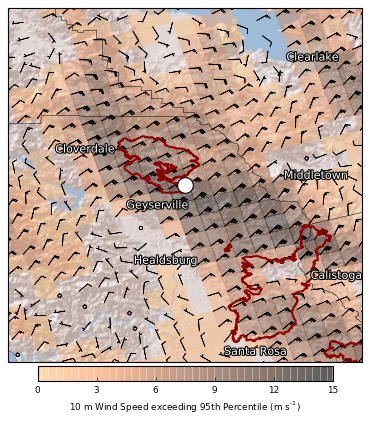

In [25]:
add_cities = True
add_fireperim = True

# Add basemap background
m.arcgisimage(service='World_Shaded_Relief', dpi=1000)


# Plot contour where speed is greater than the 95th percentile
masked = speed-p95
masked = np.ma.array(masked)
masked[masked < 0] = np.ma.masked

m.pcolormesh(lon, lat, masked,
             cmap='copper_r',
             vmax=15, vmin=0,
             alpha=.4,
             zorder=1,
             latlon=True)
cb = plt.colorbar(orientation='horizontal', pad=.01, shrink=.7)
cb.set_label(r'10 m Wind Speed exceeding 95th Percentile (m s$\mathregular{^{-1}}$)')
cb.set_ticks([range(0,16,3)])

# Wind barbs
# Cut box for plotting barbs
bfr=15
thin=1
Cgridlat = lat[x-bfr:x+bfr, y-bfr:y+bfr]
Cgridlon = lon[x-bfr:x+bfr, y-bfr:y+bfr]
CHu = Hu['value'][x-bfr:x+bfr, y-bfr:y+bfr]
CHv = Hv['value'][x-bfr:x+bfr, y-bfr:y+bfr]
m.barbs(Cgridlon[::thin,::thin], Cgridlat[::thin,::thin],
        CHu[::thin,::thin], CHv[::thin,::thin],
        zorder=2, length=4.5, linewidth=.65,
        barb_increments={'half':2.5, 'full':5,'flag':25},
        latlon=True)

# Point of MesoWest station (map center)
m.scatter(MWlon, MWlat, latlon=True, c='w', s=200, zorder=3)

# Add county lines
m.drawcounties(linewidth=.25)

#plt.title(DATE.strftime('%Y-%b-%d %H:%M UTC'), loc='left')
#plt.title(stn, fontweight='bold', loc='right')

if add_cities:
    cities = {'Geyserville': (38.700078, -122.883772),
              'Santa Rosa': (38.452214, -122.717661),
              'Healdsburg': (38.606396, -122.869722),
              'Cloverdale': (38.794959, -123.006450),
              'Middletown': (38.750411, -122.615162),
              'Clearlake': (38.950727, -122.620816),
              'Calistoga': (38.580932, -122.580472)}

    import matplotlib.patheffects as path_effects
    for c in cities:
        text = plt.text(cities[c][1], cities[c][0], c,
                        color='white', ha='center', va='center')
        text.set_path_effects([path_effects.Stroke(linewidth=2, foreground='black'),
                               path_effects.Normal()])


if add_fireperim:
    pocket = '/uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/fire_shapefiles/2017_pocket/ca_pocket_20171025_2130_dd83'
    m.readshapefile(pocket, 'pocket', drawbounds=False)
    
    tubbs = '/uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/fire_shapefiles/2017_tubbs/ca_tubbs_20171025_2130_dd83'
    m.readshapefile(tubbs, 'tubbs', drawbounds=False)
    
    nuns = '/uufs/chpc.utah.edu/common/home/u0553130/oper/HRRR_fires/fire_shapefiles/2017_nuns/ca_nuns_20171025_2130_dd83'
    m.readshapefile(nuns, 'nuns', drawbounds=False)

    for info, shape in zip(m.pocket, m.pocket):
        fire_x, fir_y = zip(*shape) 
        m.plot(fire_x, fir_y, marker=None, color='darkred')
    for info, shape in zip(m.tubbs, m.tubbs):
        fire_x, fir_y = zip(*shape) 
        m.plot(fire_x, fir_y, marker=None, color='darkred')
    for info, shape in zip(m.nuns, m.nuns):
        fire_x, fir_y = zip(*shape) 
        m.plot(fire_x, fir_y, marker=None, color='darkred')
   
plt.savefig('./figs/Fig_07_alt_Area-map-HRRR-winds_greater_than_p95p100')

## Thumbnail image of larger area for inset

In [30]:
# Create Map Object
M = Basemap(projection='cyl', resolution='f', area_thresh=1000,
            llcrnrlon=MWlon-2.3,  urcrnrlon=MWlon+4,
            llcrnrlat=MWlat-5.3, urcrnrlat=MWlat+4)

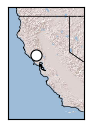

In [118]:
# Thumbnail for inset
plt.figure(figsize=[2,1.8])
M.drawstates(linewidth=.5)
M.drawcoastlines(linewidth=.5)
M.arcgisimage(service='World_Shaded_Relief', dpi=1000)

M.scatter(MWlon, MWlat, latlon=True, c='w', s=100, zorder=500)
plt.savefig('./figs/california', transparent=True)